# **Socio-economic Factors for Geographic Clustering**

-----------------------------------------
## **Context**
-----------------------------------------

The study of socio-economic factors is foundational to understanding and shaping the future of societies and hence of extreme interest to various government and non-government institutions. While GDP is one of the important measures used in one of the popular economic vernacular, it is not the only measure of the growth and the state of an economy. This case study aims to deep dive into one such dataset that contains various socio-economic attributes for countries around the world.

-----------------------------------------
## **Objective**
-----------------------------------------

To identify if there exist various clusters of countries that are more similar to each other than others, in terms of certain socio-economic factors.

------------------------
## **Data Dictionary**
-------------------------
The data has the following attributes:
- country: Name of the country
- child_mort: Death of children under 5 years of age per 1000 live births
- exports - Exports in % of the GDP per capita
- health - The total spend on health given as % of GDP
- imports - The value of imports given as % of GDP per capita
- income - The net income per person
- inflation - Inflation rate %
- life_expec - Average life expectancy in years
- total_fer - The fertility rate - Average children per woman in the country
- gdpp - GDP per capita

In the dataset, we will not do clustering on the GDP. We will rather try to understand the variation of other factors with GDP across the groups that we get.

In [51]:
import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


Insights
- There are 167 observations and 10 feature columns in the data.
- All the feature column are of integer datatype except for country names.
- Rest everything seems fine so let's proceed.

In [15]:
df[df.duplicated()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp


- No Duplicate values are present in the data.

## **Exploratory Data Analysis**

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


Insights
- The child mortality rate ranges from 2.6 to 208 with an average mortality of 38 death per 1000 live birth.
- Similarly export & import have high ranges of values with max values 200% and 174% respectively.
- Total health spend is quite normal nothing unique to report.
- Inflation in some countries have been dropping as the min values has gone into -4.2 which seems pretty unique compare to current scenario.
- Overall, % expenditure on health and average life expectancy seem to have a lesser standard deviation, which reflects less variability across countries. All other variables seem to have a very high spread across countries. These are the variables that might help us identify the clusters if they exist.

### **Let's check the distribution and outliers for each column in the data**

In [25]:
df.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

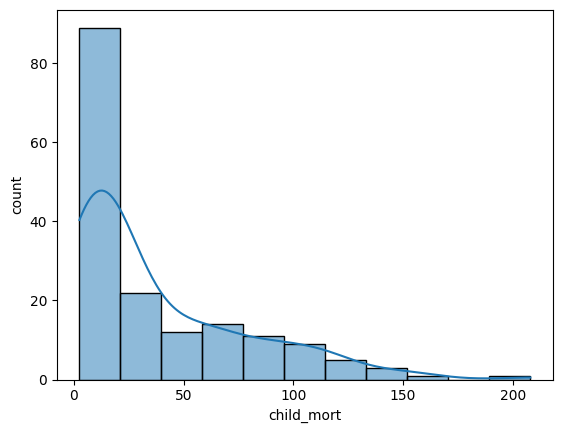

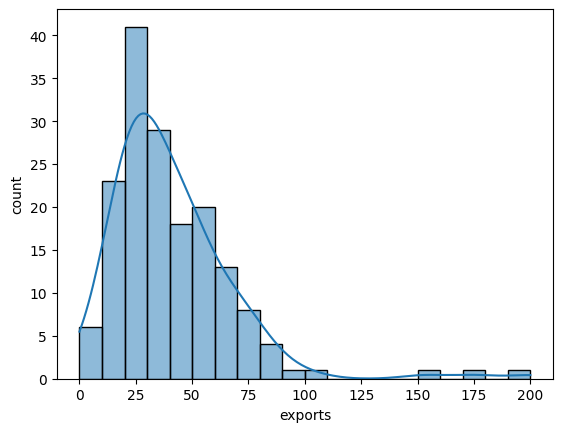

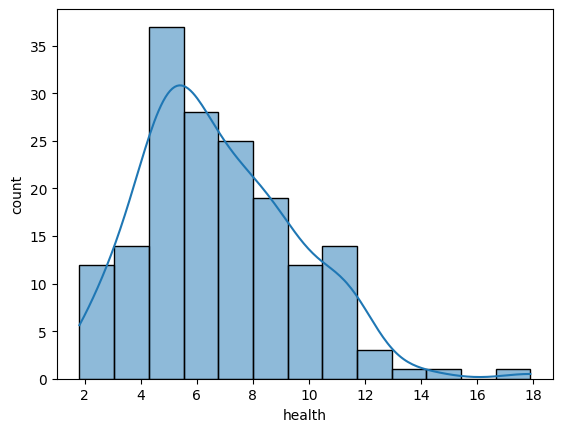

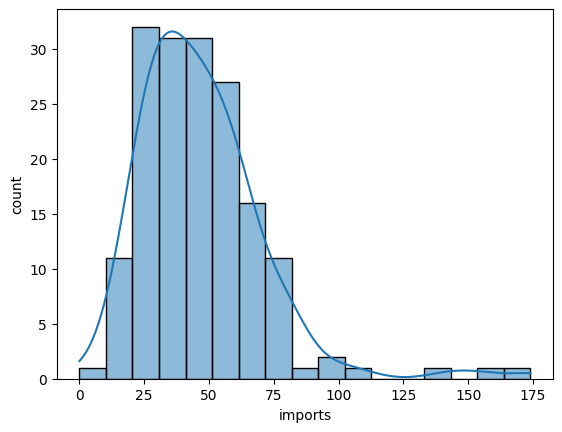

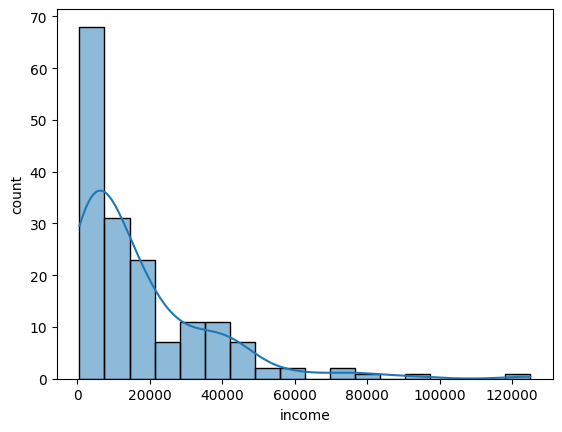

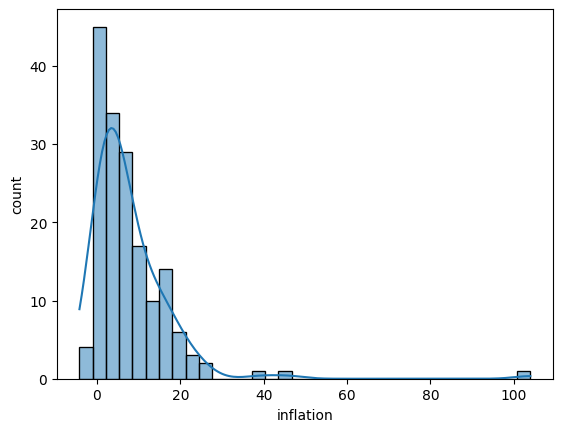

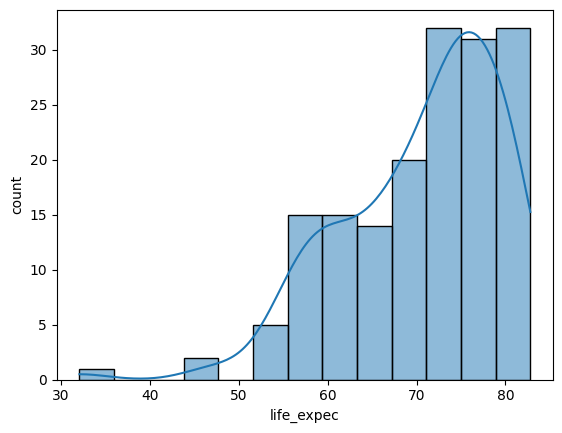

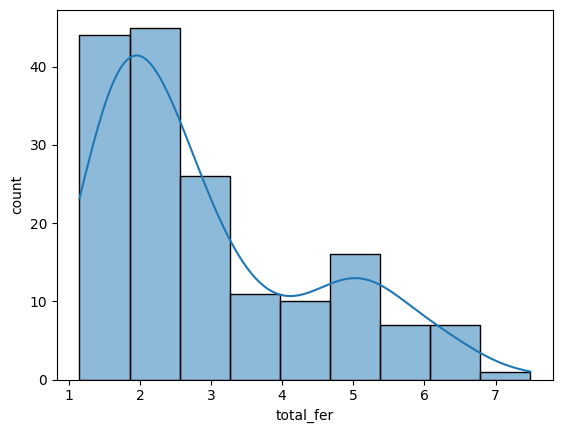

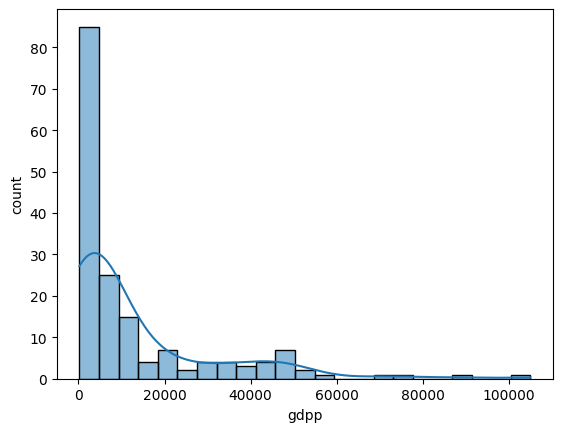

In [28]:
for feature in df.columns:
    if df[feature].dtype == 'int64' or df[feature].dtype =='float64':
        sns.histplot(df[feature],kde = True)
        plt.xlabel(feature)
        plt.ylabel('count')
        plt.show()

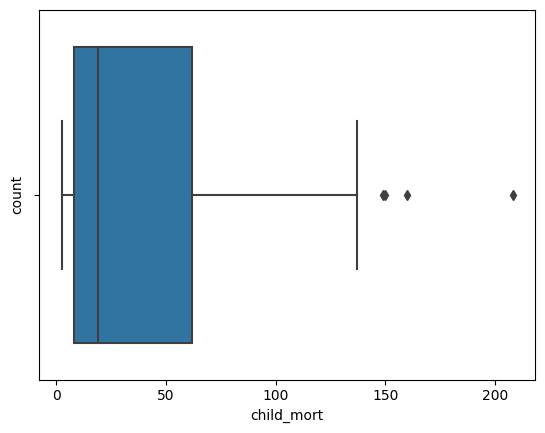

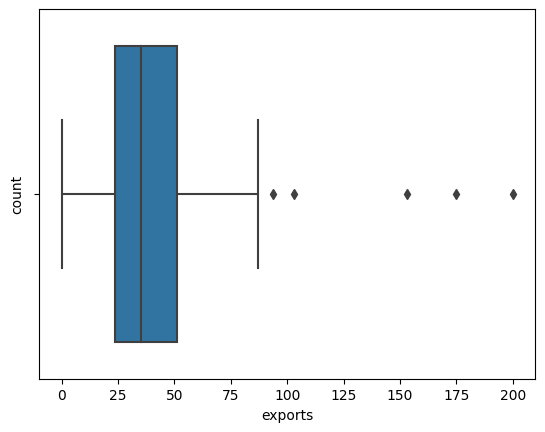

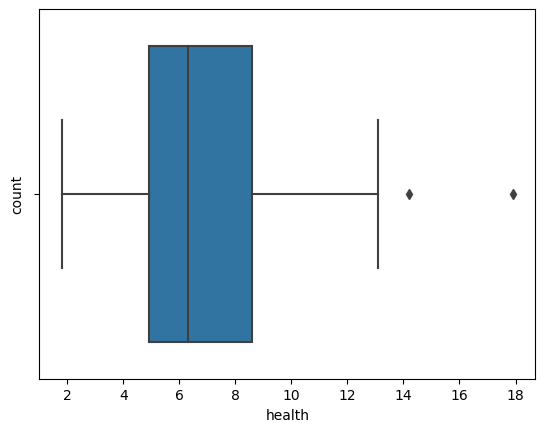

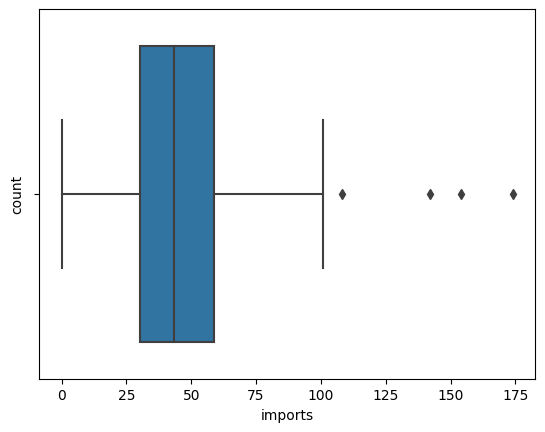

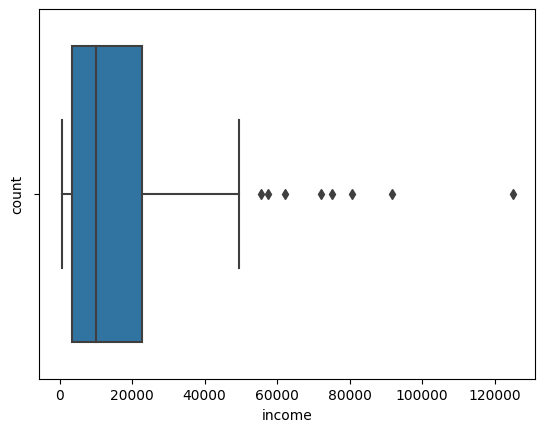

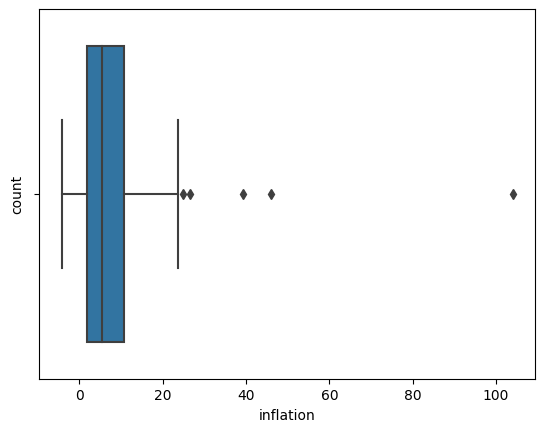

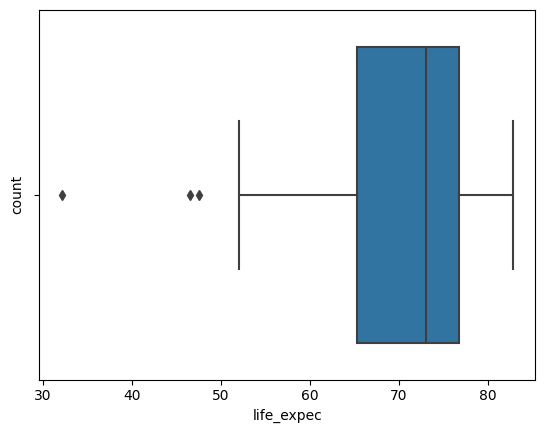

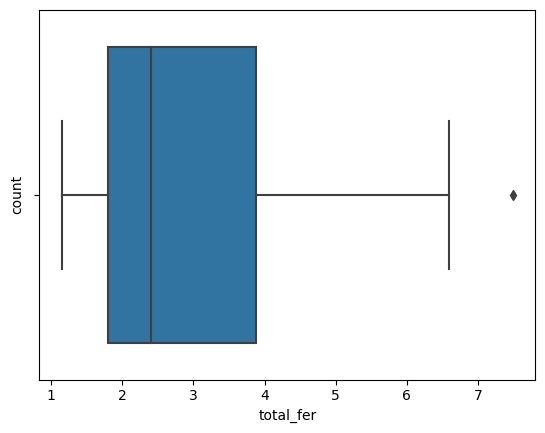

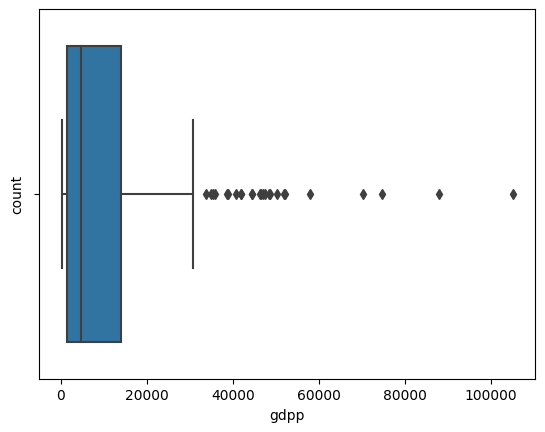

In [29]:
for feature in df.columns:
    if df[feature].dtype == 'int64' or df[feature].dtype =='float64':
        sns.boxplot(df[feature])
        plt.xlabel(feature)
        plt.ylabel('count')
        plt.show()

Insights 
- The child mortality data is right skewed with some outliers.
- Similarly import & export have data skewed to right with outliers.
- Life expectency has data skewed towards the left which makes sense that there would be more death after certain age.
- There have been some outliers in income & inflation as well observed through the boxplot.

## **Scaling the data**

- Clustering algorithms are distance-based algorithms, and all distance-based algorithms are affected by the scale of the variables. Therefore, we will scale the data before applying clustering.
- We will drop the variables `'country'` variable because it is unique for each country and would not add value to clustering. 
- We will also drop the `'gdpp'` variable for now, because we want to see if we can identify clusters of countries without relying on GDP and see later if these clusters correspond to an average GDP value for the countries in each cluster.  

In [37]:
data = df.drop(columns = ['country','gdpp'],axis = 1)
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13


In [38]:
scaler = StandardScaler()

scaled_data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

scaled_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946


In [40]:
# Creating copy of the data to store labels from each algorithm
data_scaled_copy = scaled_data.copy(deep = True)
data_scaled_copy

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946
...,...,...,...,...,...,...,...,...
162,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754
163,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678
164,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206
165,0.448417,-0.406478,-0.597272,-0.517472,-0.658924,1.500916,-0.344633,1.140944


## K-Means Clustering

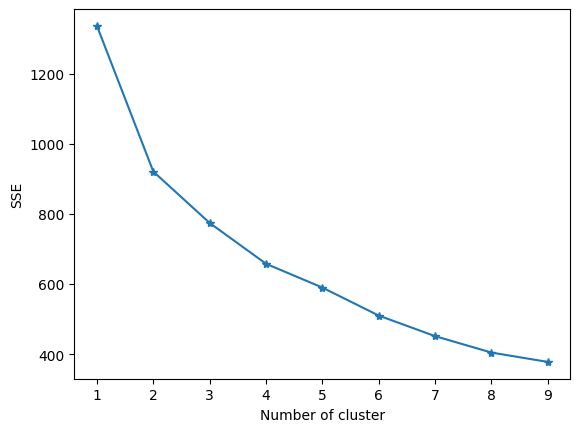

In [50]:
# Empty dictionary to store the SSE for each value of K
ss = {}

# Iterate for a range of Ks and fit the scaled data to the algorithm. 
# Use inertia attribute from the clustering object and store the inertia value for that K 
for k in range(1,10):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(scaled_data)
    ss[k] = kmeans.inertia_

# Elbow Plot
plt.plot(list(ss.keys()),list(ss.values()),'*-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Insights 
- We can see from the plot that there is a consistent dip from 2 to 8 and there doesn't seem to be a clear 'elbow' here. We may choose any number of clusters from 2 to 8. 
- So, let's look at another method to get a 'second opinion'. Let's create a plot with Silhouette scores to see how it varies with K.

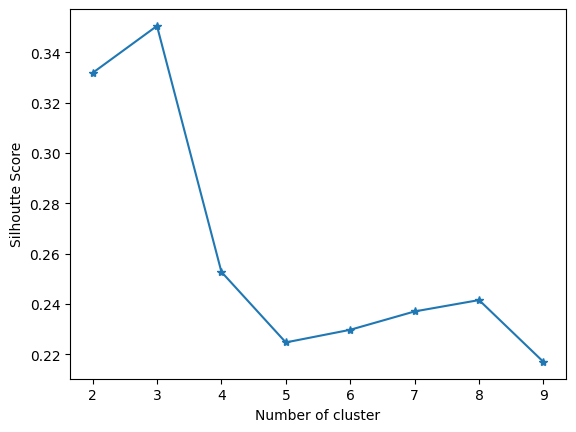

In [56]:
# Empty dictionary to store the Silhouette score for each value of K
sc = {}

# Iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that K 
for k in range(2,10):
    kmeans = KMeans(n_clusters=k,random_state=1).fit(scaled_data)
    label = kmeans.predict(scaled_data)
    sc[k] =  silhouette_score(scaled_data,label)
    
# Elbow Plot
plt.plot(list(sc.keys()),list(sc.values()),'*-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhoutte Score")
plt.show()

Insight 
- We observe from the plot that the silhouette score is the highest for K=3. Let's first understand these 3 clusters.

In [59]:
kmeans = KMeans(n_clusters = 3, random_state = 1)

kmeans.fit(scaled_data)

# Adding predicted labels to the original data and the scaled data 
data_scaled_copy['KMeans_Labels'] = kmeans.predict(scaled_data)

data['KMeans_Labels'] = kmeans.predict(scaled_data)

In [60]:
data.tail(20)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,KMeans_Labels
147,71.9,18.7,6.01,29.1,2090,9.25,59.3,5.43,1
148,14.9,66.5,3.88,60.8,13500,4.08,76.6,1.55,0
149,62.6,2.2,9.12,27.8,1850,26.50,71.1,6.23,1
150,90.3,40.2,7.65,57.3,1210,1.18,58.7,4.87,1
151,17.4,12.4,5.07,60.3,4980,3.68,69.9,3.91,0
152,17.4,50.5,6.21,55.3,10400,3.82,76.9,2.14,0
153,19.1,20.4,6.74,25.5,18000,7.01,78.2,2.15,0
154,62.0,76.3,2.50,44.5,9940,2.31,67.9,2.83,0
155,81.0,17.1,9.01,28.6,1540,10.60,56.8,6.15,1
156,11.7,47.1,7.72,51.1,7820,13.40,70.4,1.44,0


In [62]:
data['KMeans_Labels'].value_counts()

0    112
1     52
2      3
Name: KMeans_Labels, dtype: int64

Insight
- This looks like a very skewed clustering, with only three observations in one cluster and more than a hundred in another. Let's check out the profiles of these clusters.

#### Calculating the mean and the median of the original data for each label

In [64]:
mean = data.groupby('KMeans_Labels').mean()
mean.T

KMeans_Labels,0,1,2
child_mort,15.703571,88.844231,4.133333
exports,43.487500,28.203827,176.000000
health,7.069464,6.270385,6.793333
imports,46.143750,42.164729,156.666667
income,22069.285714,3832.750000,64033.333333
inflation,6.042920,11.833750,2.468000
life_expec,75.215179,59.892308,81.433333
total_fer,2.119821,4.822115,1.380000


In [65]:
median = data.groupby('KMeans_Labels').median()
median.T

KMeans_Labels,0,1,2
child_mort,12.450,85.65,2.80
exports,39.600,23.30,175.00
health,6.790,5.48,7.77
imports,44.900,39.75,154.00
income,16250.000,1960.00,72100.00
inflation,3.810,8.95,3.62
life_expec,75.800,60.45,81.30
total_fer,1.995,5.00,1.36


In [68]:
df_Kmeans = pd.concat([mean,median],axis = 0)
df_Kmeans.index = ['Cluster 0 Mean','Cluster 1 Mean','Cluster 2 Mean','Cluster 0 Median','Cluster 1 Median','Cluster 2 Median']
df_Kmeans.T

,Cluster 0 Mean,Cluster 1 Mean,Cluster 2 Mean,Cluster 0 Median,Cluster 1 Median,Cluster 2 Median
child_mort,15.703571,88.844231,4.133333,12.450,85.65,2.80
exports,43.487500,28.203827,176.000000,39.600,23.30,175.00
health,7.069464,6.270385,6.793333,6.790,5.48,7.77
imports,46.143750,42.164729,156.666667,44.900,39.75,154.00
income,22069.285714,3832.750000,64033.333333,16250.000,1960.00,72100.00
inflation,6.042920,11.833750,2.468000,3.810,8.95,3.62
life_expec,75.215179,59.892308,81.433333,75.800,60.45,81.30
total_fer,2.119821,4.822115,1.380000,1.995,5.00,1.36


Insights 
- It looks like Cluster 2 belongs to high income countries which also have high gdpp. 
- Cluster 1 seems to be of low income countries, with low mean gdp as well. 
- The remaining countries are in Cluster 0 which also happens to be the biggest cluster. Since the number of developing countries is larger than the group of highly developed countries, this intuitively makes sense.

Let us now visualize the summary statistics of these clusters below.

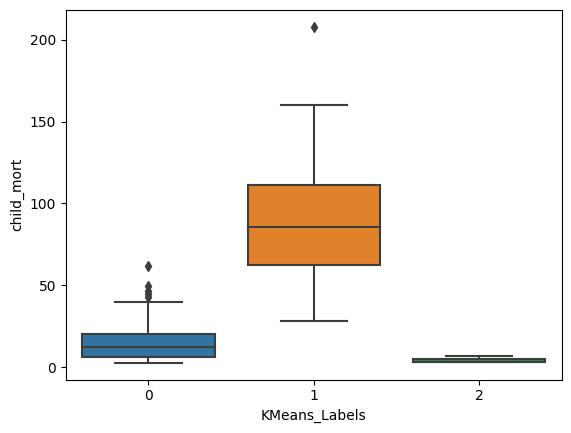

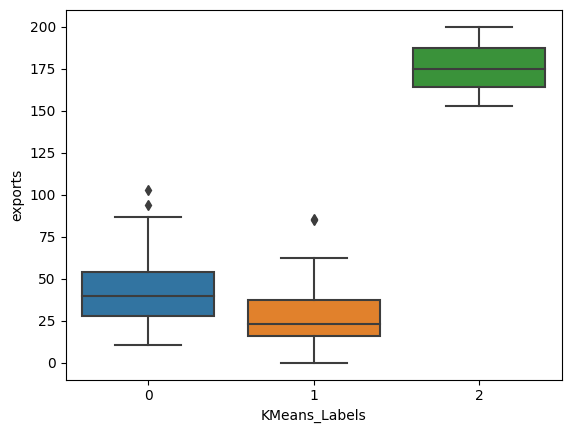

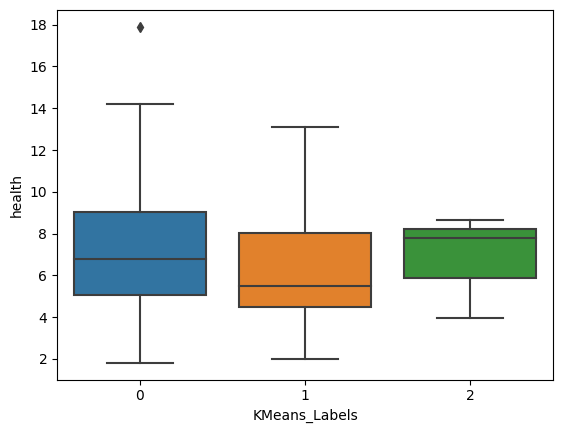

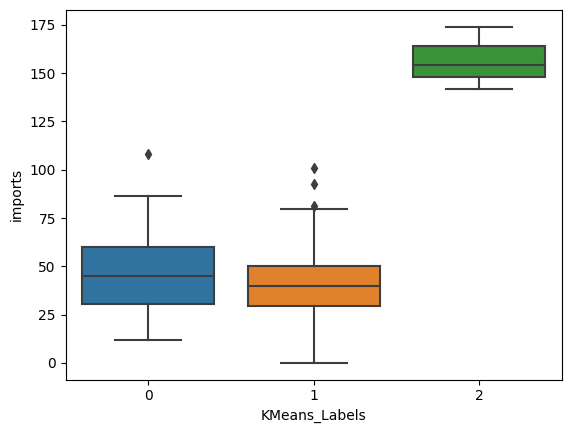

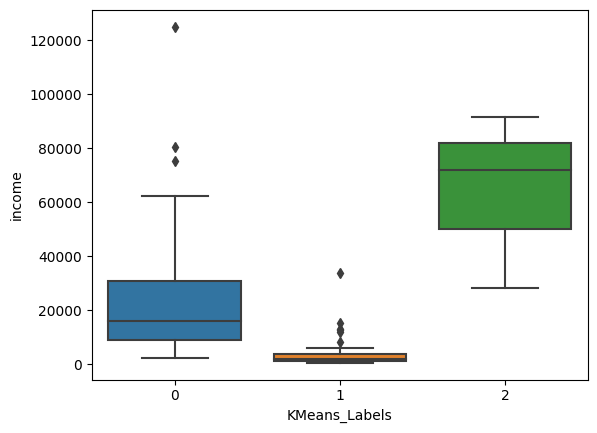

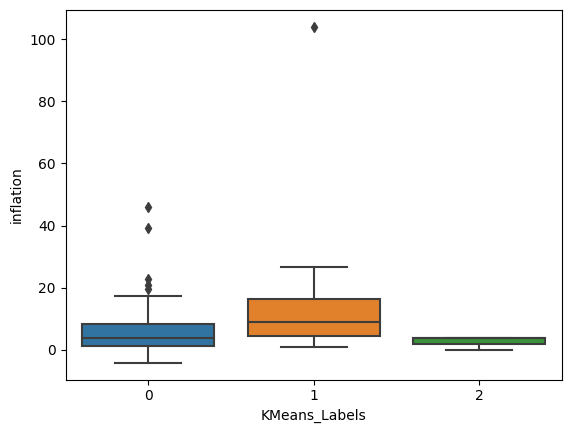

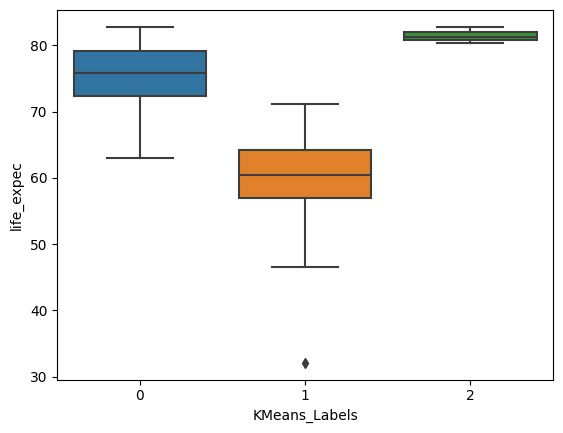

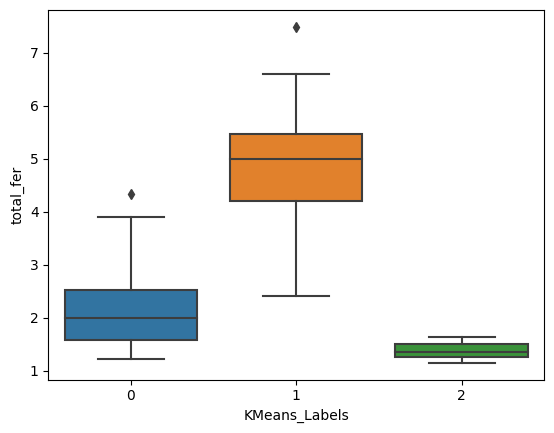

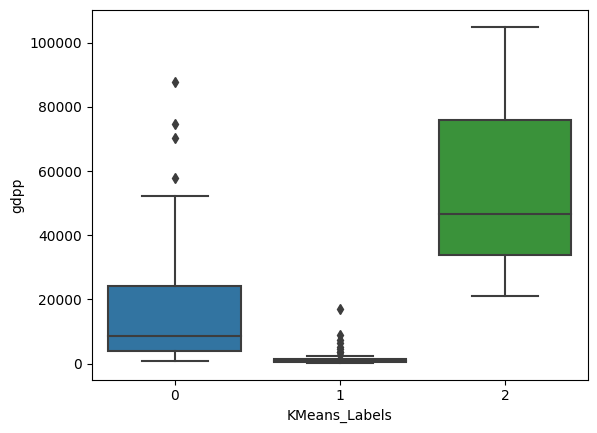

In [85]:
col_visualize = []
for i in df.columns:
    if df[i].dtype != 'object':
        col_visualize.append(i)
        
data['gdpp'] = df['gdpp']
for col in col_visualize:
    sns.boxplot(x = 'KMeans_Labels', y = col,data = data )
    plt.show()

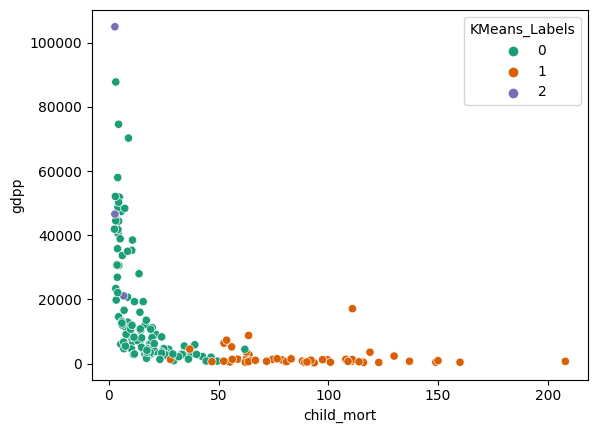

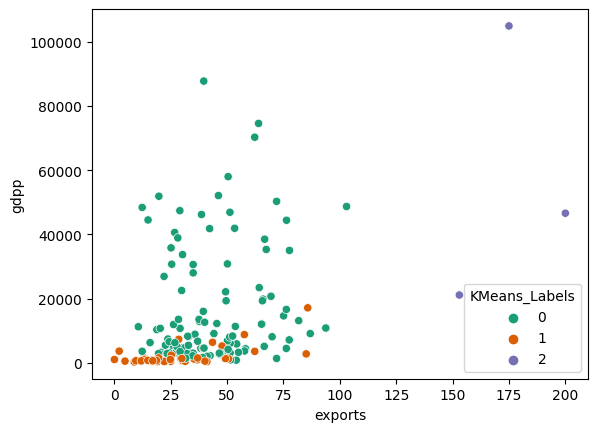

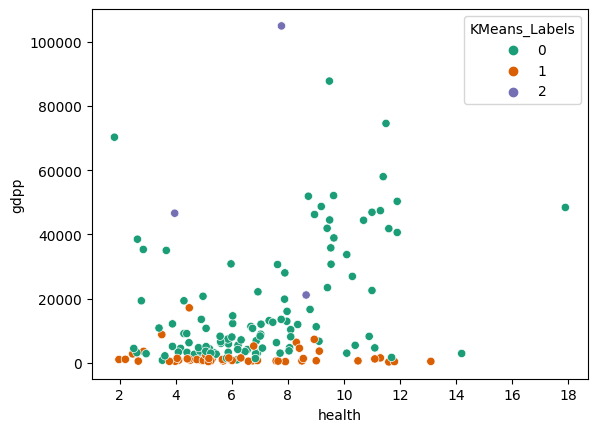

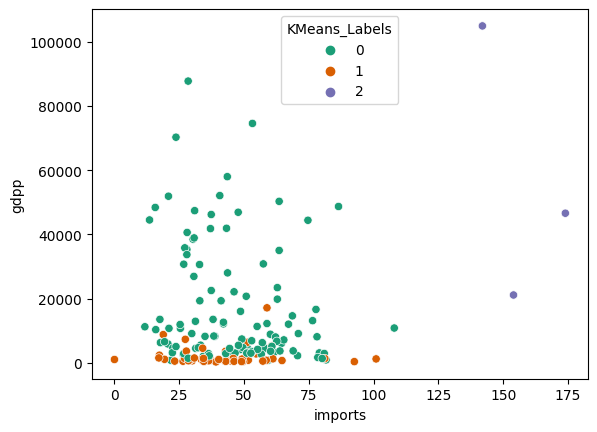

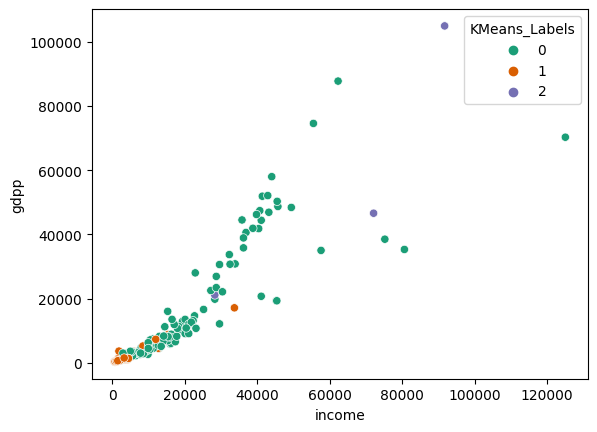

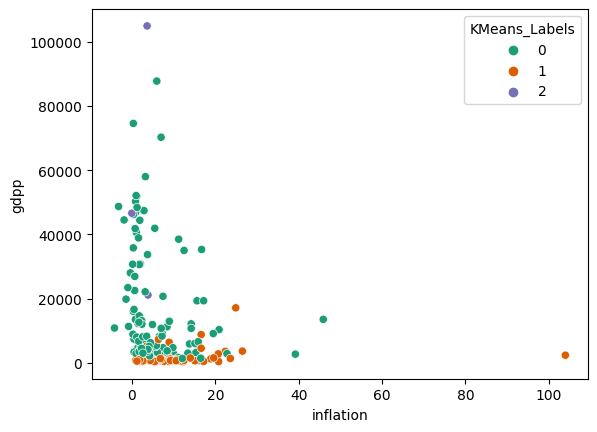

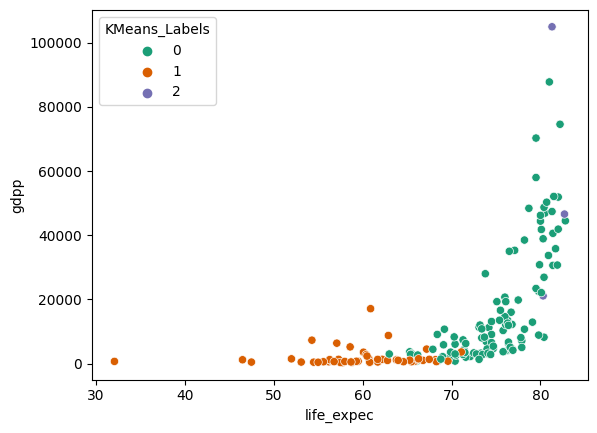

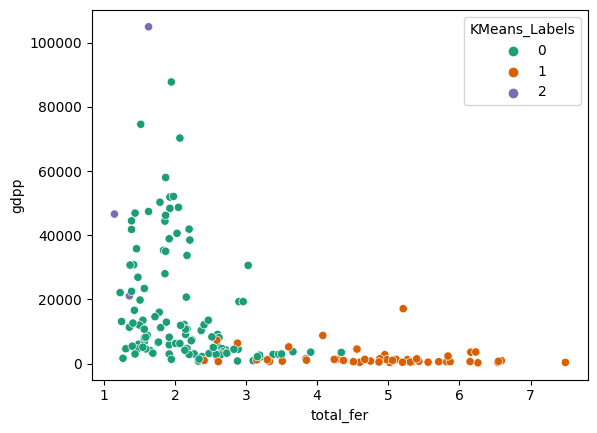

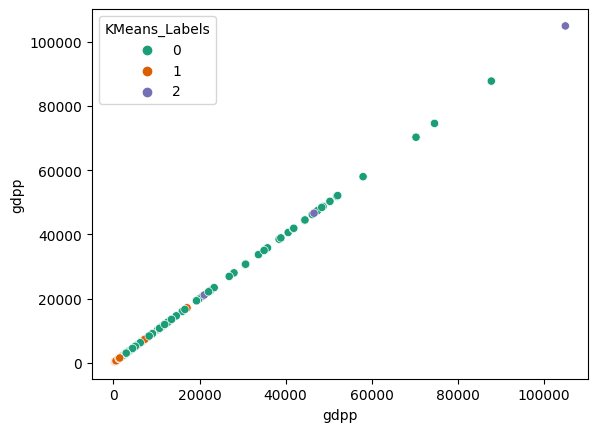

In [86]:
for col in col_visualize:
    sns.scatterplot(x = col, y = 'gdpp', data = data, hue = 'KMeans_Labels', palette = 'Dark2')
    plt.show()

**Cluster Profiles:**

- Cluster 2 has only 3 observations. As observed from the scatter plots and the boxplots, this group **consists of outlier high income countries** with the highest percentages of imports and exports in terms of GDP.
- Cluster 1 seems to have countries with less desirable values for many indicators. These countries seem to have the highest inflation rates, the lowest GDP per capita, the lowest exports as well as imports - all signaling a very poor economic situation. These countries also have the highest child mortalities, the highest fertility rates, and the lowest life expectancies. These characteristics are traits of **underdeveloped or developing countries**. These countries also seem to have a trade deficit, i.e., more imports than exports, and as a consequence, may be more reliant on borrowing and lines of credit to finance their economy.
- Cluster 0 is the largest cluster with traits of countries that fall in the **middle of the development spectrum**. These countries have a comparatively better state of affairs than the countries in cluster 1. However, this cluster has a large range of values, indicating that it is a mix of many different types of countries. Ideally, we do not want a cluster to be like this as the fundamental idea behind clustering is to 'group similar things' and this cluster seems to have a lot of 'dissimilarity' within it.
- Overall, this clustering solution does give us good insights into potential clusters of similar countries but is not very useful as it is impacted by outlier countries resulting in one very small cluster and two very big clusters. We should try other algorithms to see if we can do better. 